# Cleaning the Data

In [1]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pathlib import Path
from sqlalchemy import create_engine, text
from pprint import pprint
import plotly.graph_objects as go
import plotly.express as px
import textwrap
import dash
from dash import dcc, html, Input, Output

%matplotlib inline


In [2]:
# Load the dataset
file_path = './Resources/U.S._Chronic_Disease_Indicators.csv'
data = pd.read_csv(file_path)

In [3]:
data.head()

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,Response,DataValueUnit,DataValueType,...,TopicID,QuestionID,ResponseID,DataValueTypeID,StratificationCategoryID1,StratificationID1,StratificationCategoryID2,StratificationID2,StratificationCategoryID3,StratificationID3
0,2019,2019,AR,Arkansas,BRFSS,Diabetes,Diabetes among adults,NaN,%,Crude Prevalence,...,DIA,DIA01,NaN,CRDPREV,SEX,SEXM,NaN,NaN,NaN,NaN
1,2019,2019,ID,Idaho,BRFSS,Diabetes,Diabetes among adults,NaN,%,Crude Prevalence,...,DIA,DIA01,NaN,CRDPREV,SEX,SEXM,NaN,NaN,NaN,NaN
2,2019,2019,IN,Indiana,YRBSS,Sleep,Short sleep duration among high school students,NaN,%,Crude Prevalence,...,SLEP,SLP02,NaN,CRDPREV,GRADE,GRD12,NaN,NaN,NaN,NaN
3,2019,2019,IA,Iowa,NVSS,Asthma,"Asthma mortality among all people, underlying ...",NaN,Number,Number,...,AST,AST01,NaN,NMBR,OVERALL,OVR,NaN,NaN,NaN,NaN
4,2019,2019,IA,Iowa,BRFSS,Asthma,Current asthma among adults,NaN,%,Crude Prevalence,...,AST,AST02,NaN,CRDPREV,AGE,AGE1844,NaN,NaN,NaN,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309215 entries, 0 to 309214
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   YearStart                  309215 non-null  int64  
 1   YearEnd                    309215 non-null  int64  
 2   LocationAbbr               309215 non-null  object 
 3   LocationDesc               309215 non-null  object 
 4   DataSource                 309215 non-null  object 
 5   Topic                      309215 non-null  object 
 6   Question                   309215 non-null  object 
 7   Response                   0 non-null       float64
 8   DataValueUnit              309215 non-null  object 
 9   DataValueType              309215 non-null  object 
 10  DataValue                  209196 non-null  float64
 11  DataValueAlt               209196 non-null  float64
 12  DataValueFootnoteSymbol    101716 non-null  object 
 13  DataValueFootnote          10

In [5]:
# Drop columns with 0 non-null values
# Drop only the columns that exist in the dataset
columns_to_drop = [
    'Response', 'StratificationCategory2', 'Stratification2', 'StratificationCategory3', 'Stratification3', 
    'ResponseID', 'StratificationCategoryID2', 'StratificationID2','StratificationCategoryID3', 
    'StratificationID3', 'YearStart', 
    'DataValueFootnoteSymbol', 'DataValueFootnote', 'StratificationID1', 'StratificationCategoryID1'
    
]

# Filter columns_to_drop to include only existing columns
columns_to_drop = [col for col in columns_to_drop if col in data.columns]

# Drop the filtered list of columns
data.drop(columns=columns_to_drop, inplace=True)

print("Dropped unnecessary columns successfully!")


Dropped unnecessary columns successfully!


In [6]:
# Fill missing 'Geolocation' with 'Unknown'
data['Geolocation'].fillna('Unknown', inplace=True)

In [7]:
# Extract longitude and latitude into separate columns
data[['Longitude', 'Latitude']] = data['Geolocation'].str.extract(r'POINT \(([-\d.]+) ([-\d.]+)\)')
#Rename Columns
data.rename(columns={'YearEnd': 'Year'}, inplace=True)
data.rename(columns={'LocationDesc': 'Location'}, inplace=True)
data.rename(columns={'DataValue': 'Value'}, inplace=True)

In [8]:
# Drop duplicate rows
data = data.drop_duplicates()

In [9]:
# List of stratification categories
StratificationCategory1 = ['Sex', 'Age', 'Race/Ethnicity', 'Grade', 'Overall']

# Pivot the data: Create separate columns for each StratificationCategory
for category in StratificationCategory1:
    # Assign values from Stratification1 where StratificationCategory1 matches the current category
    data[category] = data['Stratification1'].where(data['StratificationCategory1'] == category)

# Drop the original columns if no longer needed
data.drop(columns=['StratificationCategory1', 'Stratification1'], inplace=True)

# Fill missing values in the new columns with 'Unknown' (optional)
data[StratificationCategory1] = data[StratificationCategory1].fillna('Unknown')

In [10]:
#Drop 'Overall' Column
data.drop(columns=[ 'Overall','DataValueAlt'], inplace=True)

In [11]:
print(data.columns)

Index(['Year', 'LocationAbbr', 'Location', 'DataSource', 'Topic', 'Question',
       'DataValueUnit', 'DataValueType', 'Value', 'LowConfidenceLimit',
       'HighConfidenceLimit', 'Geolocation', 'LocationID', 'TopicID',
       'QuestionID', 'DataValueTypeID', 'Longitude', 'Latitude', 'Sex', 'Age',
       'Race/Ethnicity', 'Grade'],
      dtype='object')


In [12]:
# Define the new column order
new_column_order = ['Year','Sex', 'Age', 'Grade', 'Race/Ethnicity', 'DataSource',
                    'Location', 'LocationAbbr', 'LocationID','Geolocation', 'Longitude', 'Latitude', 
                    'Topic', 'TopicID', 'Question', 'QuestionID', 'Value', 'DataValueUnit',
                    'DataValueType', 'DataValueTypeID', 'LowConfidenceLimit', 'HighConfidenceLimit' ]
# Reorder the DataFrame
data_reordered = data[new_column_order]

# Columns sorted by data source type
data = data_reordered.sort_values(by=['DataSource'], ascending=[True])
data.reset_index(drop=True, inplace=True)

In [13]:
# Review the final data set
print(data)

        Year      Sex      Age     Grade  \
0       2019  Unknown  Unknown   Unknown   
1       2019     Male  Unknown   Unknown   
2       2021  Unknown  Unknown   Unknown   
3       2019  Unknown  Unknown   Unknown   
4       2021  Unknown  Unknown   Unknown   
...      ...      ...      ...       ...   
309210  2021  Unknown  Unknown   Unknown   
309211  2021  Unknown  Unknown   Unknown   
309212  2021  Unknown  Unknown  Grade 12   
309213  2019     Male  Unknown   Unknown   
309214  2019  Unknown  Unknown   Unknown   

                                        Race/Ethnicity DataSource  \
0                                             Hispanic        ACS   
1                                              Unknown        ACS   
2                                  Black, non-Hispanic        ACS   
3                                              Unknown        ACS   
4                                  Black, non-Hispanic        ACS   
...                                                ...   

In [14]:
# Save the dataset as a CSV file
file_path = './Resources/final2_cleaned_dataset.csv'
data = pd.read_csv(file_path)
data.to_csv(file_path, index=False)  


# Creating a Database

In [15]:
# Step 2: Connect to a SQLite database (it creates the file if it doesn't exist)
sqlite_file = './Resources/U.S._Chronic_Disease_Indicators_2.sqlite'  # This is the SQLite file name
conn = sqlite3.connect(sqlite_file)  # This creates or opens the SQLite file

# Step 3: Write the DataFrame to the SQLite database
table_name = 'U.S._Chronic_Disease_Indicators'  # Name of the table in SQLite
data.to_sql(table_name, conn, if_exists='replace', index=False)

# Step 4: Verify the data has been written (optional)
query = f"SELECT * FROM `{table_name}` LIMIT 5;"  # Query to fetch the first 5 rows
result = pd.read_sql_query(query, conn)
print("Preview of the data written to the SQLite database:")
print(result)

# Step 5: Close the connection
conn.close()

print(f"Database '{sqlite_file}' has been created with table '{table_name}'.")


Preview of the data written to the SQLite database:
   Year      Sex      Age    Grade       Race/Ethnicity DataSource  \
0  2019  Unknown  Unknown  Unknown             Hispanic        ACS   
1  2019     Male  Unknown  Unknown              Unknown        ACS   
2  2021  Unknown  Unknown  Unknown  Black, non-Hispanic        ACS   
3  2019  Unknown  Unknown  Unknown              Unknown        ACS   
4  2021  Unknown  Unknown  Unknown  Black, non-Hispanic        ACS   

     Location LocationAbbr  LocationID  \
0  California           CA           6   
1    New York           NY          36   
2     Georgia           GA          13   
3        Utah           UT          49   
4      Nevada           NV          32   

                                      Geolocation  ...  \
0   POINT (-120.99999953799971 37.63864012300047)  ...   
1    POINT (-75.54397042699964 42.82700103200045)  ...   
2    POINT (-83.62758034599966 32.83968109300048)  ...   
3  POINT (-111.58713063499971 39.360700171

# Visualizations

## How do health issues and their key measures, including risk factors, compare across topics, and what patterns or differences emerge in their importance and connections?

In [16]:
file_path = './Resources/final2_cleaned_dataset.csv'
data = pd.read_csv(file_path)

# Define your SQLite database path
db_file = './Resources/DW_cleaned_data.db'

# Connect to SQLite database (creates the file if it doesn't exist)
conn = sqlite3.connect(db_file)
cursor = conn.cursor()


# Define the table schema based on the dataset columns
cursor.execute('''
CREATE TABLE IF NOT EXISTS health_data (
    Year INTEGER,
    Sex TEXT,
    Age TEXT,
    Grade TEXT,
    Race_Ethnicity TEXT,
    DataSource TEXT,
    Location TEXT,
    LocationID TEXT,
    LocationID_1 INTEGER,
    Geolocation TEXT,
    Topic TEXT,
    TopicID TEXT,
    Question TEXT,
    QuestionID TEXT,
    Value REAL,
    DataValueUnit TEXT,
    DataValueType TEXT,
    DataValueTypeID TEXT,
    LowConfidenceLimit REAL,
    HighConfidenceLimit REAL
)
''')

# Commit the table creation
conn.commit()

# Load data from the DataFrame into the SQLite table
data.to_sql('health_data', conn, if_exists='replace', index=False)

# Confirm data insertion by querying the database
row_count = cursor.execute('SELECT COUNT(*) FROM health_data').fetchone()[0]
print(f"Rows inserted into the database: {row_count}")


Rows inserted into the database: 309215


In [17]:
# Calculate the mode for the 'Topic' column
topic_mode = data['Topic'].mode()[0]

print("The mode for the 'Topic' column is:", topic_mode)

The mode for the 'Topic' column is: Cardiovascular Disease


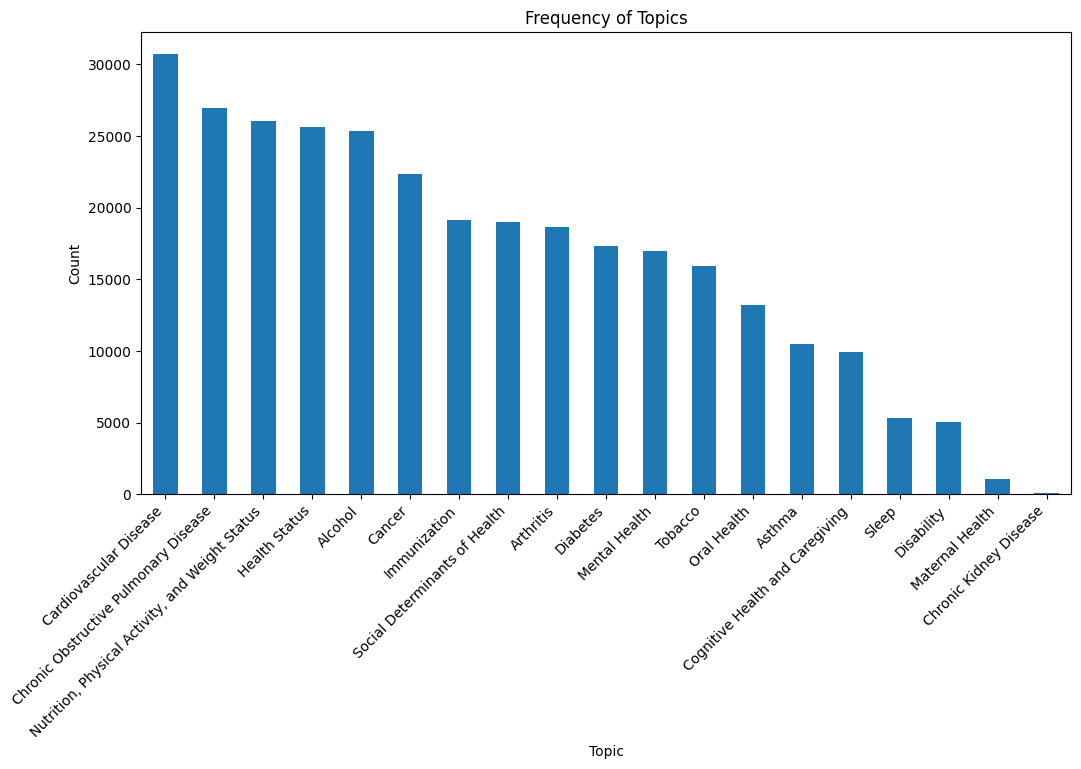

In [18]:
topic_counts = data['Topic'].value_counts()
topic_counts.plot(kind='bar', figsize=(12, 6))
plt.title('Frequency of Topics')
plt.xlabel('Topic')
plt.ylabel('Count')

plt.xticks(rotation=45, ha='right')

plt.show()

In [19]:
# Clean the dataset (ensure numeric values in Value column)
data['Value'] = pd.to_numeric(data['Value'], errors='coerce')  # Convert Value column to numeric
data = data.dropna(subset=['Value'])  # Remove rows with missing values in Value

# Aggregate data to remove duplicates
aggregated_data = data.groupby(['Year', 'Topic'], as_index=False).agg({'Value': 'mean'})
print("Aggregated Data:")
print(aggregated_data.head())
print(aggregated_data.shape)

# Pivot the dataset
pivoted_data = aggregated_data.pivot(index='Year', columns='Topic', values='Value')
print("Pivoted Data:")
print(pivoted_data.head())
print(pivoted_data.shape)

# Check for missing values in pivoted data
pivoted_data = pivoted_data.fillna(0)  # Fill missing values with 0

# Compute correlations
correlations = pivoted_data.corr()
print("Correlation Matrix:")
print(correlations)



Aggregated Data:
   Year                   Topic        Value
0  2019                 Alcohol    83.206742
1  2019               Arthritis    33.048481
2  2019                  Asthma    25.138099
3  2019                  Cancer  2202.719539
4  2019  Cardiovascular Disease  1638.525750
(67, 3)
Pivoted Data:
Topic     Alcohol  Arthritis     Asthma       Cancer  Cardiovascular Disease  \
Year                                                                           
2019    83.206742  33.048481  25.138099  2202.719539             1638.525750   
2020   117.925678        NaN  27.684740  1798.138743             2685.483736   
2021   103.008165  31.644240  25.200346          NaN             1601.739159   
2022     9.070506  26.764120  11.271670    60.236407                     NaN   

Topic  Chronic Kidney Disease  Chronic Obstructive Pulmonary Disease  \
Year                                                                   
2019              2702.197115                            3923.5995

In [20]:
# Check the schema of the table
query = "PRAGMA table_info(health_data)"
table_info = conn.execute(query).fetchall()

# Print the table schema
for column in table_info:
    print(column)

(0, 'Year', 'INTEGER', 0, None, 0)
(1, 'Sex', 'TEXT', 0, None, 0)
(2, 'Age', 'TEXT', 0, None, 0)
(3, 'Grade', 'TEXT', 0, None, 0)
(4, 'Race/Ethnicity', 'TEXT', 0, None, 0)
(5, 'DataSource', 'TEXT', 0, None, 0)
(6, 'Location', 'TEXT', 0, None, 0)
(7, 'LocationAbbr', 'TEXT', 0, None, 0)
(8, 'LocationID', 'INTEGER', 0, None, 0)
(9, 'Geolocation', 'TEXT', 0, None, 0)
(10, 'Longitude', 'REAL', 0, None, 0)
(11, 'Latitude', 'REAL', 0, None, 0)
(12, 'Topic', 'TEXT', 0, None, 0)
(13, 'TopicID', 'TEXT', 0, None, 0)
(14, 'Question', 'TEXT', 0, None, 0)
(15, 'QuestionID', 'TEXT', 0, None, 0)
(16, 'Value', 'REAL', 0, None, 0)
(17, 'DataValueUnit', 'TEXT', 0, None, 0)
(18, 'DataValueType', 'TEXT', 0, None, 0)
(19, 'DataValueTypeID', 'TEXT', 0, None, 0)
(20, 'LowConfidenceLimit', 'REAL', 0, None, 0)
(21, 'HighConfidenceLimit', 'REAL', 0, None, 0)


In [21]:
# Define the database file path
db_file = './Resources/DW_cleaned_data.db'

# Connect to the database and fetch table names
conn = sqlite3.connect(db_file)
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
conn.close()

print("Available Tables:", tables)


Available Tables: [('health_data',)]


In [22]:
# Define your SQLite database path
db_file = './Resources/DW_cleaned_data.db'

# Initialize Dash app
app = dash.Dash(__name__)
app.title = "Health Measures Dashboard"

# Connect to SQLite and load unique options for dropdowns
conn = sqlite3.connect(db_file)
topics = pd.read_sql_query('SELECT DISTINCT Topic FROM health_data', conn)['Topic'].tolist()
locations = pd.read_sql_query('SELECT DISTINCT Location FROM health_data', conn)['Location'].tolist()
years = pd.read_sql_query('SELECT DISTINCT Year FROM health_data', conn)['Year'].sort_values().tolist()
sexes = ['All'] + pd.read_sql_query('SELECT DISTINCT Sex FROM health_data', conn)['Sex'].tolist()
ages = ['All'] + pd.read_sql_query('SELECT DISTINCT Age FROM health_data', conn)['Age'].tolist()
races = ['All'] + pd.read_sql_query('SELECT DISTINCT "Race/Ethnicity" FROM health_data', conn)['Race/Ethnicity'].tolist()
conn.close()

# Define the app layout
app.layout = html.Div(style={"backgroundColor": "#f9f9f9", "fontFamily": "Arial, sans-serif", "padding": "20px"}, children=[
    # App Title
    html.H1("Interactive Health Measures Dashboard", style={
        "textAlign": "center",
        "color": "#2c3e50",
        "fontWeight": "bold",
        "fontSize": "36px",
        "marginBottom": "10px"
    }),

    # Introduction Section
    html.Div([
        html.H3("Project 11 Team 3", style={"textAlign": "center", "color": "#2c3e50", "fontWeight": "bold"}),
        html.P(
            "Healthy Living, Diverse Challenges: Exploring Health Trends by Topic and Region",
            style={"textAlign": "center", "color": "#34495e", "fontSize": "18px", "marginBottom": "10px"}
        ),
        html.P(
            "This dashboard empowers users to uncover key health trends by exploring topics, regions," 
            "and demographics. Dive into interactive visualizations to identify patterns, reveal insights," 
            "and better understand the relationships between chronic diseases, health risks," 
            "and social determinants. Our mission: Make data-driven decision-making accessible" 
            "and impactful for all.",
            style={"textAlign": "center", "color": "#34495e", "fontSize": "16px", "marginBottom": "20px"}
        )
    ], style={"marginBottom": "30px"}),

    # Filters Section
    html.Div([
        html.Label("Select Topic:", style={"fontWeight": "bold", "color": "#2c3e50"}),
        dcc.Dropdown(id="topic-dropdown", options=[{"label": t, "value": t} for t in topics], value=topics[0]),
        html.Label("Select Location:", style={"fontWeight": "bold", "color": "#2c3e50"}),
        dcc.Dropdown(id="location-dropdown", options=[{"label": l, "value": l} for l in locations], value=locations[0]),
        html.Label("Select Year:", style={"fontWeight": "bold", "color": "#2c3e50"}),
        dcc.Slider(id="year-slider", min=min(years), max=max(years), step=1, value=min(years),
                   marks={year: str(year) for year in years})
    ], style={"width": "50%", "margin": "auto", "padding": "20px", "border": "1px solid #ddd", "borderRadius": "10px", "backgroundColor": "#ffffff"}),

    # Demographic Filters Section
    html.Div([
        html.Label("Select Sex:", style={"fontWeight": "bold", "color": "#2c3e50"}),
        dcc.Dropdown(id="sex-dropdown", options=[{"label": s, "value": s} for s in sexes], value='All'),
        html.Label("Select Age:", style={"fontWeight": "bold", "color": "#2c3e50"}),
        dcc.Dropdown(id="age-dropdown", options=[{"label": a, "value": a} for a in ages], value='All'),
        html.Label("Select Race/Ethnicity:", style={"fontWeight": "bold", "color": "#2c3e50"}),
        dcc.Dropdown(id="race-dropdown", options=[{"label": r, "value": r} for r in races], value='All')
    ], style={"width": "50%", "margin": "auto", "padding": "20px", "border": "1px solid #ddd", "borderRadius": "10px", "backgroundColor": "#ffffff", "marginTop": "20px"}),

    # Graphs Section
    dcc.Graph(id="bar-chart"),
    dcc.Graph(id="choropleth-map"),
    dcc.Graph(id="line-chart"),
    dcc.Graph(id="scatter-plot"),
    dcc.Graph(id="top-questions-chart")
])

# Define callback to update visuals
@app.callback(
    Output("bar-chart", "figure"),
    Output("choropleth-map", "figure"),
    Output("line-chart", "figure"),
    Output("scatter-plot", "figure"),
    Output("top-questions-chart", "figure"),
    Input("topic-dropdown", "value"),
    Input("location-dropdown", "value"),
    Input("year-slider", "value"),
    Input("sex-dropdown", "value"),
    Input("age-dropdown", "value"),
    Input("race-dropdown", "value")
)
def update_visuals(selected_topic, selected_location, selected_year, selected_sex, selected_age, selected_race):
    # Connect to the SQLite database
    conn = sqlite3.connect(db_file)

    # Build a base query
    query = f'''
    SELECT * FROM health_data
    WHERE Topic = "{selected_topic}" 
    AND Location = "{selected_location}" 
    AND Year = {selected_year}
    '''
    
    # Add demographic filters to the query
    if selected_sex != 'All':
        query += f' AND Sex = "{selected_sex}"'
    if selected_age != 'All':
        query += f' AND Age = "{selected_age}"'
    if selected_race != 'All':
        query += f' AND "Race/Ethnicity" = "{selected_race}"'

    # Query the database
    data = pd.read_sql_query(query, conn)

    # Query for trends over time
    trend_query = f'''
    SELECT Year, AVG(Value) as AvgValue FROM health_data
    WHERE Topic = "{selected_topic}" AND Location = "{selected_location}"
    '''
    if selected_sex != 'All':
        trend_query += f' AND Sex = "{selected_sex}"'
    if selected_age != 'All':
        trend_query += f' AND Age = "{selected_age}"'
    if selected_race != 'All':
        trend_query += f' AND "Race/Ethnicity" = "{selected_race}"'
    trend_query += " GROUP BY Year"
    trend_data = pd.read_sql_query(trend_query, conn)

    # Query for top 10 questions
    top_questions_query = f'''
    SELECT Question, AVG(Value) as AvgValue FROM health_data
    WHERE Topic = "{selected_topic}"
    GROUP BY Question
    ORDER BY AvgValue DESC
    LIMIT 10
    '''
    top_questions_data = pd.read_sql_query(top_questions_query, conn)

    # Add line breaks to long question labels
    top_questions_data['Question'] = top_questions_data['Question'].apply(
        lambda q: "<br>".join(textwrap.wrap(q, width=40))
    )

    conn.close()

    # Create Visuals
    # Bar Chart
    bar_fig = px.bar(data, x="Question", y="Value", title=f"Bar Chart for {selected_topic} in {selected_location} ({selected_year})")
    bar_fig.update_layout(
        title={"x": 0.5, "font": {"size": 24, "color": "#2c3e50"}},
        plot_bgcolor="#f9f9f9", paper_bgcolor="#ffffff",
        font={"family": "Arial", "color": "#2c3e50"}
    )

    # Choropleth Map
    map_fig = px.choropleth(data, locations="LocationID", locationmode="USA-states", color="Value",
                            title="Geographic Distribution of Measures")
    map_fig.update_layout(
        title={"x": 0.5, "font": {"size": 24, "color": "#2c3e50"}},
        geo=dict(bgcolor="#f9f9f9"),
        paper_bgcolor="#ffffff",
        font={"family": "Arial", "color": "#2c3e50"}
    )

    # Line Chart
    line_fig = px.line(trend_data, x="Year", y="AvgValue", title=f"Trends for {selected_topic} in {selected_location}")
    line_fig.update_layout(
        title={"x": 0.5, "font": {"size": 24, "color": "#2c3e50"}},
        plot_bgcolor="#f9f9f9", paper_bgcolor="#ffffff",
        font={"family": "Arial", "color": "#2c3e50"}
    )

    # Scatterplot
    scatter_fig = px.scatter(data, x="LowConfidenceLimit", y="HighConfidenceLimit",
                              title="Correlation Between Confidence Limits")
    scatter_fig.update_layout(
        title={"x": 0.5, "font": {"size": 24, "color": "#2c3e50"}},
        plot_bgcolor="#f9f9f9", paper_bgcolor="#ffffff",
        font={"family": "Arial", "color": "#2c3e50"}
    )

    # Top 10 Questions Chart with Multi-Line Labels
    top_questions_fig = px.bar(
        top_questions_data,
        x="Question",
        y="AvgValue",
        title=f"Top 10 Questions for {selected_topic}",
        labels={"Question": "Questions", "AvgValue": "Average Value"}
    )
    top_questions_fig.update_layout(
        title={"x": 0.5, "font": {"size": 24, "color": "#2c3e50"}},
        xaxis={"title": "Questions", "titlefont": {"size": 18, "color": "#34495e"}},
        yaxis={"title": "Average Value", "titlefont": {"size": 18, "color": "#34495e"}},
        plot_bgcolor="#f9f9f9",
        paper_bgcolor="#ffffff",
        font={"family": "Arial", "color": "#2c3e50"}
    )

    return bar_fig, map_fig, line_fig, scatter_fig, top_questions_fig

# Run the app
if __name__ == "__main__":
    app.run_server(debug=True)


## How does smoking affect the risk of developing chronic obstructive pulmonary disease (COPD)?

In [23]:
# Load the SQLite database
db_path = './Resources/U.S._Chronic_Disease_Indicators_2.sqlite'
conn = sqlite3.connect(db_path)

# Query the table with backticks to escape the period
query = "SELECT * FROM `U.S._Chronic_Disease_Indicators`"  # Wrap table name in backticks
df = pd.read_sql_query(query, conn)

In [24]:
# Function to map ages into desired age groups
def group_age(age):
    if isinstance(age, str):
        if age in ['Age 18-44', 'Age 0-44']:
            return '18-44'
        elif age == 'Age >=65':
            return '65+'
        elif age == 'Age 45-64':
            return '45-64'
        elif age in ['Age 1-5', 'Age 4 m - 5 y']:
            return '0-5'
        elif age in ['Age 12-17', 'Age 6-14', 'Age 6-11', 'Age 10-13', 'Age 6-9']:
            return '6-17'
        return 'Unknown'
    return 'Unknown'

# Apply the function to the 'Age' column
df['Age'] = df['Age'].apply(group_age)

In [25]:
# Filter rows based on relevant topics
filtered_data = df[df['Topic'].str.contains(
    'Tobacco|Health Status|Chronic Obstructive Pulmonary Disease|Social Determinants of Health',
    case=False, na=False
)]

# Filter for smoking-related and COPD-related questions
smoking_copd_data = filtered_data[filtered_data['Question'].str.contains(
    'smoking|COPD', case=False, na=False
)]


In [26]:
# Reword questions
reworded_questions = {
   'Current cigarette smoking among adults': 'Current Smoking Among Adults',
    'Current smoking among adults with chronic obstructive pulmonary disease': 'Smoking Among Adults with COPD',
    'Chronic obstructive pulmonary disease among adults': 'COPD Prevalence Among Adults',
    'Hospitalization for chronic obstructive pulmonary disease as any diagnosis, Medicare-beneficiaries aged 65 years and older': 'COPD Hospitalizations in Medicare Beneficiaries (65+)',  # Merged
    'Hospitalization for chronic obstructive pulmonary disease as principal diagnosis, Medicare-beneficiaries aged 65 years and older': 'COPD Hospitalizations in Medicare Beneficiaries (65+)',  # Merged
    'Chronic obstructive pulmonary disease mortality among adults aged 45 years and older, underlying or contributing cause': 'COPD Mortality Among Adults (45+)',  # Merged
    'Chronic obstructive pulmonary disease mortality among adults aged 45 years and older, underlying cause': 'COPD Mortality Among Adults (45+)'  # Merged
}

df['Reworded Question'] = df['Question'].replace(reworded_questions)

# Filter relevant data
smoking_copd_data = df[df['Reworded Question'].isin(reworded_questions.values())]

# Ensure 'Value' is numeric
smoking_copd_data.loc[:, 'Value'] = pd.to_numeric(smoking_copd_data['Value'], errors='coerce')



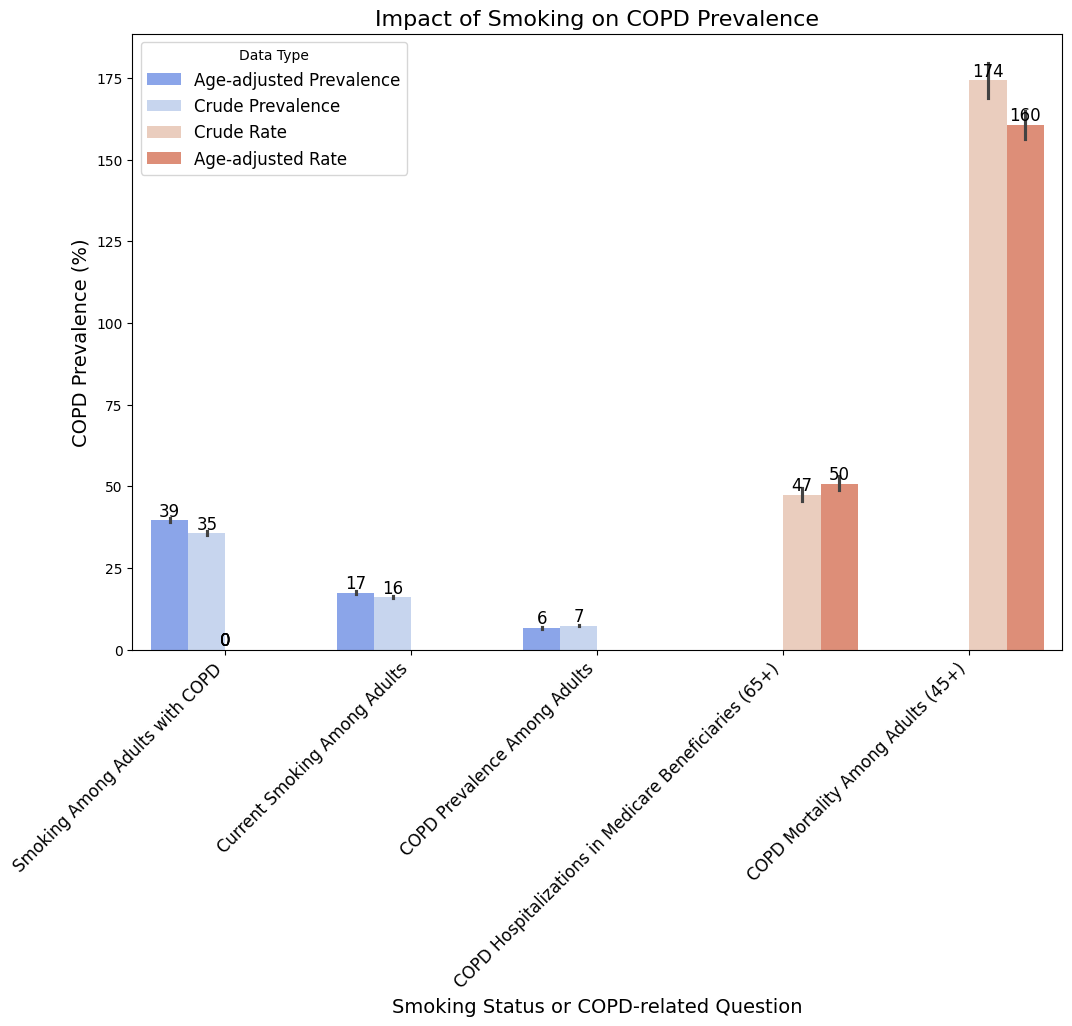

In [27]:
# Bar plot for smoking and COPD
plt.figure(figsize=(12, 8))
filtered_data = smoking_copd_data[~smoking_copd_data['DataValueType'].str.contains('Number', case=False, na=False)]
ax = sns.barplot(x='Reworded Question', y='Value', data=filtered_data, hue='DataValueType', palette='coolwarm')

# Add labels above bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom', fontsize=12)

# Set labels and save
plt.title('Impact of Smoking on COPD Prevalence', fontsize=16)
plt.xlabel('Smoking Status or COPD-related Question', fontsize=14)
plt.ylabel('COPD Prevalence (%)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.legend(title='Data Type', fontsize=12)
plt.savefig('./Output/VM_BarChart.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 1200x800 with 0 Axes>

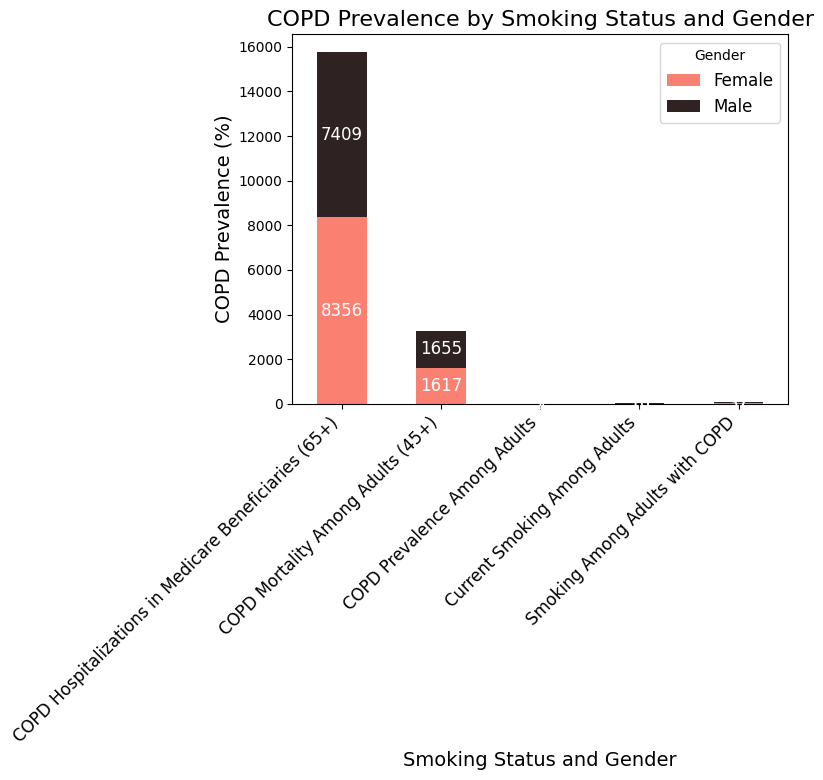

In [28]:
# Assuming you have your grouped data
# Filter data to exclude 'Unknown' sex
smoking_copd_data = smoking_copd_data[smoking_copd_data['Sex'] != 'Unknown']

# Group the data by 'Question' and 'Sex', and calculate the mean COPD prevalence for each group
grouped_data = smoking_copd_data.groupby(['Reworded Question', 'Sex'])['Value'].mean().reset_index()

# Create a pivot table to have questions on the x-axis and different sexes as columns
pivot_data = grouped_data.pivot_table(index='Reworded Question', columns='Sex', values='Value', aggfunc='mean', fill_value=0)

# Create the figure with transparent background
plt.figure(figsize=(12, 8), facecolor='none')

# Plot the stacked bar chart
ax = pivot_data.plot(kind='bar', stacked=True, colormap=sns.color_palette("dark:salmon_r", as_cmap=True))

# Add numbers (whole numbers) above the bars with white lettering in the center of the bar
for p in ax.patches:
    height = p.get_height()
    width = p.get_width()
    x_position = p.get_x() + width / 2  # Center the text horizontally
    y_position = p.get_y() + height / 2  # Center the text vertically (middle of the bar)

    # Add text above each bar with white color and centered in the middle
    ax.text(
        x_position,  # X position (center of the bar)
        y_position,  # Y position (middle of the bar)
        f'{int(height)}',  # Display the height as a whole number
        ha='center',  # Horizontal alignment (so text is centered)
        va='center',  # Vertical alignment (so text is centered)
        fontsize=12,  # Font size for the numbers
        color='white'  # Text color set to white
    )

# Set labels and save with transparent background
plt.title('COPD Prevalence by Smoking Status and Gender', fontsize=16)
plt.xlabel('Smoking Status and Gender', fontsize=14)
plt.ylabel('COPD Prevalence (%)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.legend(title='Gender', fontsize=12, loc='upper right')

# Save the plot as a PNG image with transparent background
plt.savefig('./Output/VM_Stacked_BarChart.png', dpi=300, bbox_inches='tight', transparent=True)

# Show the plot
plt.show()

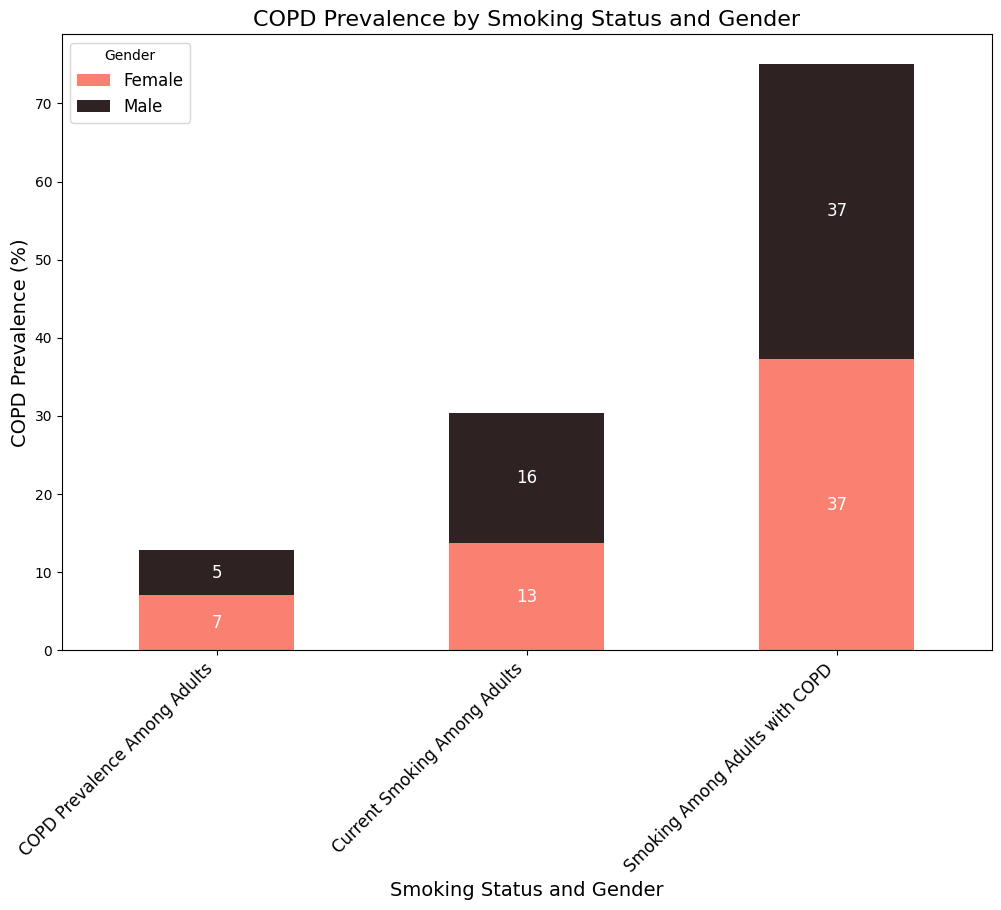

In [29]:
# Assuming 'smoking_copd_data' is your DataFrame with the necessary data
# Filter data to exclude 'Unknown' sex and only include relevant questions
smoking_copd_data = smoking_copd_data[smoking_copd_data['Sex'] != 'Unknown']

# Filter to include only specific questions
filtered_data = smoking_copd_data[smoking_copd_data['Reworded Question'].isin([
    'Current Smoking Among Adults',
    'Smoking Among Adults with COPD',
    'COPD Prevalence Among Adults'
])]

# Group the data by 'Reworded Question' and 'Sex', and calculate the mean COPD prevalence for each group
grouped_data = filtered_data.groupby(['Reworded Question', 'Sex'])['Value'].mean().reset_index()

# Create a pivot table to have questions on the x-axis and different sexes as columns
pivot_data = grouped_data.pivot_table(index='Reworded Question', columns='Sex', values='Value', aggfunc='mean', fill_value=0)

# Plotting the stacked bar chart with 'Question' on x-axis and 'Sex' in legend
ax = pivot_data.plot(kind='bar', stacked=True, figsize=(12, 8), colormap=sns.color_palette("dark:salmon_r", as_cmap=True))

# Add numbers (whole numbers) above the bars with white lettering in the center of the bar
for p in ax.patches:
    height = p.get_height()
    width = p.get_width()
    x_position = p.get_x() + width / 2  # Center the text horizontally
    y_position = p.get_y() + height / 2  # Center the text vertically (middle of the bar)

    # Add text above each bar with white color and centered in the middle
    ax.text(
        x_position,  # X position (center of the bar)
        y_position,  # Y position (middle of the bar)
        f'{int(height)}',  # Display the height as a whole number
        ha='center',  # Horizontal alignment (so text is centered)
        va='center',  # Vertical alignment (so text is centered)
        fontsize=12,  # Font size for the numbers
        color='white'  # Text color set to white
    )

# Set labels and save with transparent background
plt.title('COPD Prevalence by Smoking Status and Gender', fontsize=16)
plt.xlabel('Smoking Status and Gender', fontsize=14)
plt.ylabel('COPD Prevalence (%)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.legend(title='Gender', fontsize=12, loc='upper left')

# Save the plot as a PNG image
plt.savefig('./Output/VM_Stacked_BarChart2.png', dpi=300, bbox_inches='tight', transparent=True)

# Show the plot
plt.show()

## How do cardiovascular disease rates differ across gender, age, and lifestyle factors like diet and exercise?

In [31]:
# Load the data into a DataFrame
raw_df = pd.read_csv("./Resources/U.S._Chronic_Disease_Indicators.csv")

sqlite_file = './Resources/U.S._Chronic_Disease_Indicators_Avery.sqlite'  # This is the SQLite file name
conn = sqlite3.connect(sqlite_file)  # This creates or opens the SQLite file

# Write the DataFrame to the SQLite database
table_name = 'US_Chronic_Disease_Indicators'  # Name of the table in SQLite
raw_df.to_sql(table_name, conn, if_exists='replace', index=False)

# View the data
query = f"SELECT * FROM `{table_name}` LIMIT 5;"  # Query to fetch the first 5 rows
result = pd.read_sql_query(query, conn)

In [32]:
query = "SELECT * FROM US_Chronic_Disease_Indicators"
sql_df = pd.read_sql(query, conn)

sql_df.head(10)

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,Response,DataValueUnit,DataValueType,...,TopicID,QuestionID,ResponseID,DataValueTypeID,StratificationCategoryID1,StratificationID1,StratificationCategoryID2,StratificationID2,StratificationCategoryID3,StratificationID3
0,2019,2019,AR,Arkansas,BRFSS,Diabetes,Diabetes among adults,None,%,Crude Prevalence,...,DIA,DIA01,None,CRDPREV,SEX,SEXM,None,None,None,None
1,2019,2019,ID,Idaho,BRFSS,Diabetes,Diabetes among adults,None,%,Crude Prevalence,...,DIA,DIA01,None,CRDPREV,SEX,SEXM,None,None,None,None
2,2019,2019,IN,Indiana,YRBSS,Sleep,Short sleep duration among high school students,None,%,Crude Prevalence,...,SLEP,SLP02,None,CRDPREV,GRADE,GRD12,None,None,None,None
3,2019,2019,IA,Iowa,NVSS,Asthma,"Asthma mortality among all people, underlying ...",None,Number,Number,...,AST,AST01,None,NMBR,OVERALL,OVR,None,None,None,None
4,2019,2019,IA,Iowa,BRFSS,Asthma,Current asthma among adults,None,%,Crude Prevalence,...,AST,AST02,None,CRDPREV,AGE,AGE1844,None,None,None,None
5,2019,2019,IA,Iowa,NVSS,Diabetes,"Diabetes mortality among all people, underlyin...",None,Number,Number,...,DIA,DIA03,None,NMBR,AGE,AGE0_44,None,None,None,None
6,2019,2019,IA,Iowa,BRFSS,Health Status,Recent activity limitation among adults,None,Number,Crude Mean,...,HEA,HEA04,None,CRDMEAN,SEX,SEXF,None,None,None,None
7,2019,2019,IA,Iowa,BRFSS,Mental Health,Depression among adults,None,%,Crude Prevalence,...,MEN,MEN02,None,CRDPREV,RACE,MRC,None,None,None,None
8,2019,2019,KS,Kansas,NVSS,Diabetes,"Diabetes mortality among all people, underlyin...",None,Number,Number,...,DIA,DIA03,None,NMBR,AGE,AGE4564,None,None,None,None
9,2019,2019,LA,Louisiana,BRFSS,Mental Health,Depression among adults,None,%,Crude Prevalence,...,MEN,MEN02,None,CRDPREV,RACE,HIS,None,None,None,None


In [33]:
# Close the connection
conn.close()

In [34]:
# Drop null and unnecessary columns from the df
columns_to_drop = ["YearStart","LocationAbbr","Response","DataValueAlt","DataValueFootnoteSymbol",
                   "StratificationCategory2","Stratification2","StratificationCategoryID1","DataValueTypeID","QuestionID","ResponseID",
                   "StratificationCategory3","Stratification3","StratificationCategoryID2","StratificationID2","StratificationCategoryID3",
                   "StratificationID3","LocationID","LowConfidenceLimit","HighConfidenceLimit","DataValueFootnote","DataSource",
                   "StratificationCategory1",]
dropped_df = sql_df.drop(columns_to_drop, axis=1)

In [35]:
# Rename columns for better readability
renamed_df = dropped_df.rename(columns = {"YearEnd": "Year Recorded", "LocationDesc": "State", 
                                          "Stratification1": "Stratification", "StratificationID1": "StratID"})
# Sort the df by year oldest to newest and by state in alphabetical order
cleaned_df = renamed_df.sort_values(by=["Year Recorded", "State"], ascending=[True, True])
cleaned_df.reset_index(drop=True, inplace=True)

# Remove the word POINT from the Geolocation column so it just has latitude and longitude coordinates
cleaned_df["Geolocation"] = cleaned_df["Geolocation"].str.replace("POINT", "", regex=False)

# Split the Latitude and Longitude coordinates into two columns
cleaned_df[['Latitude', 'Longitude']] = cleaned_df['Geolocation'].str.extract(r'\(([^ ]+) ([^ ]+)\)')

In [36]:
# Filter data by year, state and Topic
groupby_df = cleaned_df.groupby(["Topic"]).size().reset_index(name='Topic Count per all regions')

groupby_df

,Topic,Topic Count per all regions
0,Alcohol,25321
1,Arthritis,18645
2,Asthma,10511
3,Cancer,22358
4,Cardiovascular Disease,30709
5,Chronic Kidney Disease,104
6,Chronic Obstructive Pulmonary Disease,26951
7,Cognitive Health and Caregiving,9904
8,Diabetes,17318
9,Disability,5060


In [37]:
# Filter data by my question related to Cardio Vascular Disease
cardio_df = cleaned_df[cleaned_df['Topic'].str.contains("Cardiovascular Disease", na=False)]

cardio_df.head(10)

,Year Recorded,State,Topic,Question,DataValueUnit,DataValueType,DataValue,Stratification,Geolocation,TopicID,StratID,Latitude,Longitude
172,2019,Alabama,Cardiovascular Disease,Hospitalization for heart failure as principal...,"cases per 1,000",Crude Rate,71.43,"American Indian or Alaska Native, non-Hispanic",(-86.63186076199969 32.84057112200048),CVD,AIAN,-86.63186076199969,32.84057112200048
194,2019,Alabama,Cardiovascular Disease,Cerebrovascular disease (stroke) mortality amo...,"cases per 100,000",Crude Rate,304.40,Age >=65,(-86.63186076199969 32.84057112200048),CVD,AGE65P,-86.63186076199969,32.84057112200048
199,2019,Alabama,Cardiovascular Disease,Taking medicine for high cholesterol among adults,%,Crude Prevalence,NaN,"Hawaiian or Pacific Islander, non-Hispanic",(-86.63186076199969 32.84057112200048),CVD,HAPI,-86.63186076199969,32.84057112200048
201,2019,Alabama,Cardiovascular Disease,Hospitalization for heart failure as principal...,"cases per 1,000",Age-adjusted Rate,NaN,Hispanic,(-86.63186076199969 32.84057112200048),CVD,HIS,-86.63186076199969,32.84057112200048
206,2019,Alabama,Cardiovascular Disease,Diseases of the heart mortality among all peop...,"cases per 100,000",Age-adjusted Rate,219.00,"White, non-Hispanic",(-86.63186076199969 32.84057112200048),CVD,WHT,-86.63186076199969,32.84057112200048
211,2019,Alabama,Cardiovascular Disease,Taking medicine for high cholesterol among adults,%,Crude Prevalence,54.00,Age >=65,(-86.63186076199969 32.84057112200048),CVD,AGE65P,-86.63186076199969,32.84057112200048
216,2019,Alabama,Cardiovascular Disease,High cholesterol among adults who have been sc...,%,Crude Prevalence,31.30,"American Indian or Alaska Native, non-Hispanic",(-86.63186076199969 32.84057112200048),CVD,AIAN,-86.63186076199969,32.84057112200048
222,2019,Alabama,Cardiovascular Disease,Diseases of the heart mortality among all peop...,"cases per 100,000",Crude Rate,238.40,"Black, non-Hispanic",(-86.63186076199969 32.84057112200048),CVD,BLK,-86.63186076199969,32.84057112200048
224,2019,Alabama,Cardiovascular Disease,Coronary heart disease mortality among all peo...,Number,Number,3795.00,"White, non-Hispanic",(-86.63186076199969 32.84057112200048),CVD,WHT,-86.63186076199969,32.84057112200048
228,2019,Alabama,Cardiovascular Disease,Cerebrovascular disease (stroke) mortality amo...,Number,Number,NaN,"Asian, non-Hispanic",(-86.63186076199969 32.84057112200048),CVD,ASN,-86.63186076199969,32.84057112200048


In [38]:
# Create filtered df for data with age groups
age_group_df = cardio_df[cardio_df['Stratification'].isin(['Age >=65', 'Age 45-64', 'Age 18-44', 'Age 0-44'])]
print(len(age_group_df),'Records')
age_group_df.head(10)

4125 Records


,Year Recorded,State,Topic,Question,DataValueUnit,DataValueType,DataValue,Stratification,Geolocation,TopicID,StratID,Latitude,Longitude
194,2019,Alabama,Cardiovascular Disease,Cerebrovascular disease (stroke) mortality amo...,"cases per 100,000",Crude Rate,304.4,Age >=65,(-86.63186076199969 32.84057112200048),CVD,AGE65P,-86.63186076199969,32.84057112200048
211,2019,Alabama,Cardiovascular Disease,Taking medicine for high cholesterol among adults,%,Crude Prevalence,54.0,Age >=65,(-86.63186076199969 32.84057112200048),CVD,AGE65P,-86.63186076199969,32.84057112200048
273,2019,Alabama,Cardiovascular Disease,Taking medicine to control high blood pressure...,%,Crude Prevalence,86.8,Age 45-64,(-86.63186076199969 32.84057112200048),CVD,AGE4564,-86.63186076199969,32.84057112200048
313,2019,Alabama,Cardiovascular Disease,Coronary heart disease mortality among all peo...,Number,Number,123.0,Age 0-44,(-86.63186076199969 32.84057112200048),CVD,AGE0_44,-86.63186076199969,32.84057112200048
369,2019,Alabama,Cardiovascular Disease,Coronary heart disease mortality among all peo...,"cases per 100,000",Crude Rate,434.6,Age >=65,(-86.63186076199969 32.84057112200048),CVD,AGE65P,-86.63186076199969,32.84057112200048
479,2019,Alabama,Cardiovascular Disease,Coronary heart disease mortality among all peo...,"cases per 100,000",Crude Rate,86.0,Age 45-64,(-86.63186076199969 32.84057112200048),CVD,AGE4564,-86.63186076199969,32.84057112200048
515,2019,Alabama,Cardiovascular Disease,Taking medicine for high cholesterol among adults,%,Crude Prevalence,18.5,Age 18-44,(-86.63186076199969 32.84057112200048),CVD,AGE1844,-86.63186076199969,32.84057112200048
525,2019,Alabama,Cardiovascular Disease,High blood pressure among adults,%,Crude Prevalence,20.8,Age 18-44,(-86.63186076199969 32.84057112200048),CVD,AGE1844,-86.63186076199969,32.84057112200048
531,2019,Alabama,Cardiovascular Disease,Diseases of the heart mortality among all peop...,Number,Number,2751.0,Age 45-64,(-86.63186076199969 32.84057112200048),CVD,AGE4564,-86.63186076199969,32.84057112200048
551,2019,Alabama,Cardiovascular Disease,High cholesterol among adults who have been sc...,%,Crude Prevalence,43.8,Age 45-64,(-86.63186076199969 32.84057112200048),CVD,AGE4564,-86.63186076199969,32.84057112200048


In [39]:
result = age_group_df.groupby(['State', 'Stratification'])['DataValue'].sum().unstack(fill_value=0)
result_list = result.values.tolist()
print(result)
#pprint(result_list)
# Use these reults to insert a new "properties" feature in geojson_data.js
# call it "ageGroup":[list,of,ages]

Stratification        Age 0-44  Age 18-44  Age 45-64   Age >=65
State                                                          
Alabama                 2436.7      223.5    15891.2    58650.5
Alaska                   178.8      140.0     2405.1     7347.5
Arizona                 1468.7      166.4    12160.0    68090.7
Arkansas                1470.4      201.8    11648.7    41986.9
California              6880.9      157.3    59112.3   302223.7
Colorado                 928.8      146.7     7572.6    38506.8
Connecticut              543.4      179.8     6154.0    35656.6
Delaware                 195.9      178.6     2862.3    15606.5
District of Columbia     136.0      158.5     3016.3    11436.3
Florida                 4720.0       87.4    41029.4   243425.0
Georgia                 3485.3      197.4    24637.6    80593.8
Guam                       0.0      182.3      418.9      490.3
Hawaii                   280.1      159.3     3343.9    16461.6
Idaho                    342.4      159.

In [40]:
# Create filtered df for Male and Female data
gender_df = cardio_df[cardio_df['Stratification'].isin(['Male', 'Female'])]
print(len(gender_df),'Records')
gender_df.head(10)

5504 Records


,Year Recorded,State,Topic,Question,DataValueUnit,DataValueType,DataValue,Stratification,Geolocation,TopicID,StratID,Latitude,Longitude
256,2019,Alabama,Cardiovascular Disease,Taking medicine for high cholesterol among adults,%,Age-adjusted Prevalence,31.90,Male,(-86.63186076199969 32.84057112200048),CVD,SEXM,-86.63186076199969,32.84057112200048
296,2019,Alabama,Cardiovascular Disease,Hospitalization for heart failure as principal...,"cases per 1,000",Age-adjusted Rate,29.23,Female,(-86.63186076199969 32.84057112200048),CVD,SEXF,-86.63186076199969,32.84057112200048
306,2019,Alabama,Cardiovascular Disease,High blood pressure among adults,%,Crude Prevalence,40.80,Female,(-86.63186076199969 32.84057112200048),CVD,SEXF,-86.63186076199969,32.84057112200048
312,2019,Alabama,Cardiovascular Disease,High cholesterol among adults who have been sc...,%,Age-adjusted Prevalence,31.90,Female,(-86.63186076199969 32.84057112200048),CVD,SEXF,-86.63186076199969,32.84057112200048
336,2019,Alabama,Cardiovascular Disease,Cerebrovascular disease (stroke) mortality amo...,"cases per 100,000",Age-adjusted Rate,48.70,Female,(-86.63186076199969 32.84057112200048),CVD,SEXF,-86.63186076199969,32.84057112200048
434,2019,Alabama,Cardiovascular Disease,Taking medicine to control high blood pressure...,%,Crude Prevalence,85.20,Female,(-86.63186076199969 32.84057112200048),CVD,SEXF,-86.63186076199969,32.84057112200048
438,2019,Alabama,Cardiovascular Disease,Coronary heart disease mortality among all peo...,"cases per 100,000",Age-adjusted Rate,55.70,Female,(-86.63186076199969 32.84057112200048),CVD,SEXF,-86.63186076199969,32.84057112200048
444,2019,Alabama,Cardiovascular Disease,Taking medicine for high cholesterol among adults,%,Crude Prevalence,37.40,Female,(-86.63186076199969 32.84057112200048),CVD,SEXF,-86.63186076199969,32.84057112200048
570,2019,Alabama,Cardiovascular Disease,High blood pressure among adults,%,Crude Prevalence,44.30,Male,(-86.63186076199969 32.84057112200048),CVD,SEXM,-86.63186076199969,32.84057112200048
653,2019,Alabama,Cardiovascular Disease,Coronary heart disease mortality among all peo...,"cases per 100,000",Crude Rate,122.80,Male,(-86.63186076199969 32.84057112200048),CVD,SEXM,-86.63186076199969,32.84057112200048


In [41]:
result = gender_df.groupby(['State', 'Stratification'])['DataValue'].sum().unstack(fill_value=0)
result_list = result.values.tolist()
print(result)
#pprint(result_list)
# Use these reults to insert a new "properties" feature in geojson_data.js
# call it "gender":[list,of,genders]

Stratification            Female        Male
State                                       
Alabama                 53857.19    58978.40
Alaska                   4588.46     6487.64
Arizona                 51549.80    64472.83
Arkansas                35590.71    40739.18
California             254420.11   293659.12
Colorado                30893.49    35338.23
Connecticut             34362.43    35693.88
Delaware                11815.38    13749.41
District of Columbia     8129.41     8416.17
Florida                217581.94   247476.27
Georgia                 83706.18    91328.92
Guam                      658.40      665.80
Hawaii                  11387.26    14250.50
Idaho                   12338.68    15428.10
Illinois               120286.68   124612.57
Indiana                 64143.70    69352.61
Iowa                    30185.90    33982.96
Kansas                  26033.85    29709.92
Kentucky                48693.73    53593.33
Louisiana               49349.43    54346.82
Maine     

In [42]:
pprint(result_list)

[[53857.19, 58978.4],
 [4588.46, 6487.64],
 [51549.8, 64472.83],
 [35590.71, 40739.18],
 [254420.11, 293659.12],
 [30893.49, 35338.23],
 [34362.43, 35693.88],
 [11815.38, 13749.41],
 [8129.41, 8416.17],
 [217581.94, 247476.27],
 [83706.18000000001, 91328.92],
 [658.4, 665.8],
 [11387.26, 14250.5],
 [12338.68, 15428.1],
 [120286.68000000001, 124612.57],
 [64143.7, 69352.61],
 [30185.9, 33982.96],
 [26033.85, 29709.92],
 [48693.73, 53593.33],
 [49349.43, 54346.82],
 [14259.16, 16791.72],
 [51980.23, 53552.02],
 [60918.74, 62695.96],
 [114453.46, 121977.41],
 [39195.76, 42752.38],
 [35046.9, 39394.36],
 [65499.64, 71261.9],
 [9672.33, 13043.4],
 [15564.64, 17083.79],
 [25082.47, 33671.67],
 [13297.01, 16124.62],
 [84914.37, 87356.92],
 [17508.79, 21300.55],
 [194875.54, 195128.02],
 [92209.19, 98600.41],
 [7374.62, 9143.96],
 [132282.17, 139875.74],
 [43027.13, 47611.66],
 [30815.04, 35753.46],
 [146539.29, 151569.34],
 [814.0, 796.9],
 [13719.34, 14310.5],
 [48421.81, 55274.64],
 [8919.8

In [43]:
# Save the dataset as a CSV file
cardio_df.to_csv('./Resources/AJ_cleaned_dataframe.csv', index=False)